# Key Point Prediction: Grid Search

**March 19, 2025**

# 1 Introduction

In this notebook, we look to iterate on the original notebook for predicting key points and want to see if we can improve results using a grid search.

In [4]:
!pip install deprecation
!pip install albumentations
!pip install keras_tuner
!pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


  Attempting uninstall: docker
    Found existing installation: docker 7.1.0
    Uninstalling docker-7.1.0:
      Successfully uninstalled docker-7.1.0
  Attempting uninstall: botocore
    Found existing installation: botocore 1.35.99
    Uninstalling botocore-1.35.99:
      Successfully uninstalled botocore-1.35.99
  Attempting uninstall: s3transfer
    Found existing installation: s3transfer 0.10.4
    Uninstalling s3transfer-0.10.4:
      Successfully uninstalled s3transfer-0.10.4
  Attempting uninstall: boto3
    Found existing installation: boto3 1.35.60
    Uninstalling boto3-1.35.60:
      Successfully uninstalled boto3-1.35.60
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inference 0.46.5 requires boto3<=1.35.60, but you have boto3 1.37.

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.pardir, "src"))

from soccer_util_last import *
from distance_speed_stimator import *
from ultralytics import YOLO
from grouping_teams import *
from stimating_team_position import *
from heatmap import *
from possesion_tracker import *

2025-06-29 23:49:21.770144: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-29 23:49:21.784364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-29 23:49:21.801549: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-29 23:49:21.806729: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-29 23:49:21.819426: I tensorflow/core/platform/cpu_feature_guar

# 2 Data

Here, we load the data and show how we can map the labeled key points to their respective images.

In [2]:
dataset = get_dataset()
print(dataset.shape)
print(dataset.columns)
dataset.head()

(1752, 6)
Index(['file', 'label_frame_index', 'width', 'x', 'y', 'label'], dtype='object')


,file,label_frame_index,width,x,y,label
0,edc171ee-frame_0.jpg,0,0.001159,0.453387,0.361348,Bottom Center Circle
1,edc171ee-frame_0.jpg,0,0.001159,0.467082,0.843575,Bottom Midfield
2,edc171ee-frame_0.jpg,0,0.001159,0.356315,0.297670,Left Center Circle
3,edc171ee-frame_0.jpg,0,0.001159,0.087855,0.298612,Left D
4,edc171ee-frame_0.jpg,0,-1.000000,0.000000,0.000000,Left D Bottom Intersection


In [3]:
dataset[['file', 'x','y','label']]

,file,x,y,label
0,edc171ee-frame_0.jpg,0.453387,0.361348,Bottom Center Circle
1,edc171ee-frame_0.jpg,0.467082,0.843575,Bottom Midfield
2,edc171ee-frame_0.jpg,0.356315,0.297670,Left Center Circle
3,edc171ee-frame_0.jpg,0.087855,0.298612,Left D
4,edc171ee-frame_0.jpg,0.000000,0.000000,Left D Bottom Intersection
...,...,...,...,...
1747,frame_9.jpg,0.000000,0.000000,Right D
1748,frame_9.jpg,0.000000,0.000000,Right D Bottom Intersection
1749,frame_9.jpg,0.000000,0.000000,Right D Top Intersection
1750,frame_9.jpg,0.700866,0.246854,Top Center Circle


In [4]:
print(f"'{dataset.label.iloc[1]}'")

'Bottom Midfield'


In [5]:
if False:   
    visualize_point_layout(dataset)

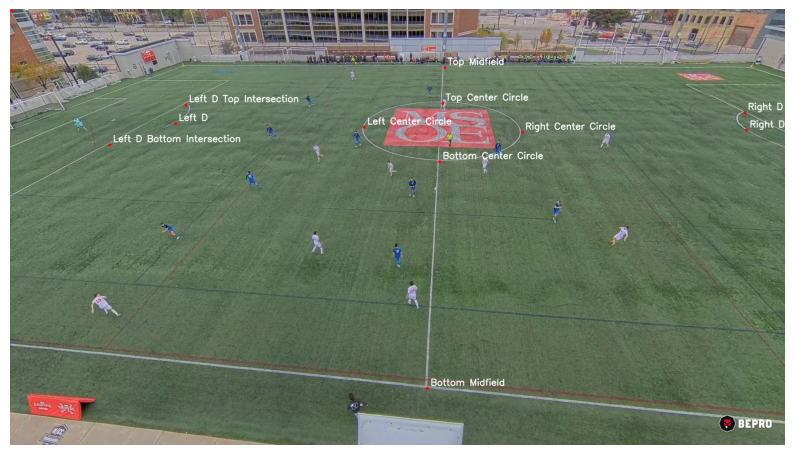

In [6]:
first_image =  cv2.imread(f"{PATH}/images/frame_8.jpg")
first_image_height, first_image_width = first_image.shape[:2]
first_image_df = dataset[dataset['file'] == 'frame_8.jpg']

for _, row in first_image_df.iterrows():
        x, y = row["x"], row["y"]
        label = row["label"]
        
        # Draw the point on the image (circle)
        x_full, y_full = int(x * first_image_width + 5), int(y * first_image_height + 5)
        cv2.circle(first_image, 
                   (x_full, y_full), 
                   radius=5, color=(0, 0, 255), thickness=-1)  # Red circle

        # Add label near the point
        cv2.putText(first_image, label, (x_full + 10, y_full - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                    fontScale=1, color=(255, 255, 255), thickness=2, lineType=cv2.LINE_AA)  # White text

image_rgb = cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis
plt.show()

## 2.1 Flip Augmentations

This has to be done somewhat delicately to not corrupt the model, but we should be able to flip the image and the notions of left/right to double our dataset and normalize a little for some dataset bias if there are more samples from one angle over others.

In [7]:
if not os.path.isdir(f"{PATH}/images/augmentations"):
    os.mkdir(f"{PATH}/images/augmentations")

augmented_sets = []

for file in dataset.file.unique():
    if "augmentations" in file:
        continue

    points = dataset[dataset.file == file].copy()
    img = cv2.imread(f"{PATH}/images/{file}")
    img = cv2.flip(img, 1)
    augmented_file = f"augmentations/flip_{file}"
    cv2.imwrite(f"{PATH}/images/{augmented_file}", img)

    points_flipped = points.copy()
    points_flipped["x"] = 1 - points["x"]
    points_flipped["label"] = points_flipped["label"].str.replace("Left", "tmp").str.replace("Right", "Left").str.replace("tmp", "Right")
    points_flipped["label_frame_index"] += dataset.shape[0]
    points_flipped = points_flipped.sort_values(by=["label_frame_index", "label"]).reset_index(drop=True)
    points_flipped["file"] = augmented_file
    augmented_sets.append(points_flipped)

augmented_dataset = pd.concat((dataset, *augmented_sets)).reset_index(drop=True)
augmented_dataset.tail()

,file,label_frame_index,width,x,y,label
3499,augmentations/flip_frame_9.jpg,1897,0.00287,0.651951,0.271556,Right D
3500,augmentations/flip_frame_9.jpg,1897,0.00287,0.730152,0.313309,Right D Bottom Intersection
3501,augmentations/flip_frame_9.jpg,1897,0.00287,0.641627,0.232556,Right D Top Intersection
3502,augmentations/flip_frame_9.jpg,1897,0.00287,0.299134,0.246854,Top Center Circle
3503,augmentations/flip_frame_9.jpg,1897,0.00287,0.291620,0.155144,Top Midfield


Then, we create train-test split with 20% of the data being used for the testing set.

In [ ]:
(
    X_train,
    X_val,
    y_visibility_train,
    y_visibility_val,
    y_coordinates_train,
    y_coordinates_val,
) = get_train_test_split(augmented_dataset, test_size=0.20)

USE_NEGATIVE_1_MASKING = True

# for this notebook, I use (-1, -1) as the location for a missing point because of the custom loss function used
if USE_NEGATIVE_1_MASKING:
    y_coordinates_train = y_coordinates_train.copy()
    for i in range(y_coordinates_train.shape[0]):
        y_coordinates_train[i, y_visibility_train[i] == 0, :] = -1

    y_coordinates_val = y_coordinates_val.copy()
    for i in range(y_coordinates_val.shape[0]):
        y_coordinates_val[i, y_visibility_val[i] == 0, :] = -1


print("X_train:", X_train.shape,
      "\nX_val:", X_val.shape,
      "\ny_visibility_train:", y_visibility_train.shape,
      "\ny_visibility_val:", y_visibility_val.shape,
      "\ny_coordinates_train:", y_coordinates_train.shape,
      "\ny_coordinates_val:", y_coordinates_val.shape
)

In [10]:
if False:
    visualize_samples(X_train, y_coordinates_train)

# 3 Model

In our model, we want to see if better configurations can be used to improve on our validation masked masked MAE loss because this will be key for getting our coordinate prediction correct. For initial hyperparamters to experiments with, we use the following in a hyperparameter grid search:

- learning rate

- number of dense neurons coming out of convolutional layers

- number of dense neurons in the layer used for further extracting features for coordinate prediction

- amount of dropout to be used during training

In [ ]:
def model_builder(hp, input_shape=(TARGET_SIZE[1], TARGET_SIZE[0], 3)):
    # --- Defining Hyperparameters ---
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    hp_decay_rate = hp.Float('decay_rate', min_value=0.95, max_value=1.0)
    hp_dense_neurons = hp.Int('hp_dense_neurons', min_value=32, max_value=512, step=32)
    hp_coord_dense_neurons = hp.Int('hp_coord_dense_neurons', min_value=32, max_value=512, step=32)
    hp_dropout_rate = hp.Choice('dropout', values=[0.1, 0.2, 0.3, 0.4])

    # --- Model Definition ---
    inputs = Input(shape=input_shape)

    # -- Convolutional Layers --
    x = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal")(inputs)
    x = MaxPooling2D(pool_size=(4, 4))(x)
    x = Dropout(hp_dropout_rate)(x)  # Added dropout

    x = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal")(x)
    x = MaxPooling2D(pool_size=(4, 4))(x)
    x = Dropout(hp_dropout_rate)(x)  # Added dropout

    x = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(hp_dropout_rate)(x)  # Added dropout

    # -- Dense Layers --
    x = Flatten()(x)
    x = Dense(hp_dense_neurons, activation="relu", kernel_initializer="he_normal")(x)
    x = Dropout(hp_dropout_rate)(x)

    coord_x = Dense(hp_coord_dense_neurons, activation="relu", kernel_initializer="he_normal")(x)

    # -- Outputs --
    # Coordinates Output (12 keypoints, each with (x, y), linear activation)
    coordinates_output = Dense(12 * 2, activation="linear", kernel_initializer="he_normal")(coord_x)
    coordinates_output = Reshape((12, 2), name="xy")(coordinates_output)

    # Visibility Output (12 units, sigmoid activation)
    visibility_output = Dense(12, activation="sigmoid", name="visible")(x)

    # Define the model with two outputs
    model = Model(inputs=inputs, outputs=[visibility_output, coordinates_output])

    # --- Optimizer ---
    initial_lr = hp_lr
    decay_rate = hp_decay_rate

    # Define the ExponentialDecay schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=1,  # The number of steps per epoch (here it decays every epoch)
        decay_rate=decay_rate,
        staircase=False  # Whether to apply the decay in a staircase fashion
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the model with a combined loss function
    model.compile(
        optimizer=optimizer,
        loss={"visible": "binary_crossentropy", "xy": MaskedMAELoss()},
        loss_weights={"visible": 1, "xy": 10},
        metrics={"visible": RoundedAccuracy(), "xy": "mae"},
    )

    return model

We define our model tuner using a Hyperband search in accordance with the tuner defined in this tutorial (https://www.tensorflow.org/tutorials/keras/keras_tuner).

In [ ]:
project_name = 'hp_search_v6'
tuner = kt.BayesianOptimization(
    model_builder,
    objective=kt.Objective("val_xy_loss", direction="min"),
    max_trials=50,
    directory='model_dir',
    project_name=project_name
)

early_stopping = EarlyStopping(
    monitor="loss",  # Metric to monitor (use 'val_loss' or 'val_accuracy', etc.)
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Whether to restore model weights from the epoch with the best value of the monitored quantity
    mode="min",  # 'min' for minimizing the monitored quantity, 'max' for maximizing
)

In [ ]:
if False:
    tuner.search(
        X_train,
        [y_visibility_train, y_coordinates_train],
        epochs=200,
        batch_size=4,
        validation_data=(X_val, [y_visibility_val, y_coordinates_val]),
        callbacks=[early_stopping],
    )

We look at the best model hyperparameters found from the search.

In [ ]:
# best_hps = tuner.get_best_hyperparameters()[0]
# print(json.dumps(best_hps.values, indent=4))

And then we refit this model so we can get a look at results.

In [ ]:
FIT_MODEL = False

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

if FIT_MODEL:
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(
        X_train,
        [y_visibility_train, y_coordinates_train],
        epochs=200,
        batch_size=4,
        validation_data=(X_val, [y_visibility_val, y_coordinates_val]),
        callbacks=[early_stopping],
    )
    model.save(f"/data/ai_club/SoccerStats2024/keypoint_model_v0_03_20_2025_{project_name}.keras")
else:
    model =keras.models.load_model(
        f"/data/ai_club/SoccerStats2024/keypoint_model_v0_03_20_2025_{project_name}.keras",
        custom_objects={
            "MaskedMAELoss": MaskedMAELoss(),
            "RoundedAccuracy": RoundedAccuracy(),
        },
    )

In [27]:
if FIT_MODEL:
    plot_training_run(history)
else:
    print("Model was loaded in from previous run.")

NameError: name 'FIT_MODEL' is not defined

# 4 Evaluation

In [ ]:
import tensorflow as tf
print(tf.sysconfig.get_build_info())

OrderedDict([('cpu_compiler', '/opt/rh/gcc-toolset-11/root/usr/bin/gcc'), ('cuda_compute_capabilities', ['sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_90']), ('cuda_version', '12.4'), ('cudnn_version', '9'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', True)])


In [ ]:
import torch
print(torch.version.cuda)
from matplotlib.lines import Line2D

12.1


In [ ]:
USE_TRAINING_DATA = False
INDEX = 2
SHOW_AVERAGE_POINTS = False
if USE_TRAINING_DATA:
    evaluate_prediction(
        augmented_dataset,
        model,
        MaskedMAELoss(),
        X_train,
        y_visibility_train,
        y_coordinates_train,
        index=INDEX,
        show_average_points=SHOW_AVERAGE_POINTS,
    )
else:
    evaluate_prediction(
        augmented_dataset,
        model,
        MaskedMAELoss(),
        X_val,
        y_visibility_val,
        y_coordinates_val,
        index=INDEX,
        show_average_points=SHOW_AVERAGE_POINTS,
    )

2025-04-12 21:02:50.568663: I external/local_xla/xla/service/service.cc:168] XLA service 0x558df14adba0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-04-12 21:02:50.568730: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-04-12 21:02:50.607959: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


I0000 00:00:1744506170.846579  444656 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-12 21:02:50.848421: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


: 

: 

In [ ]:
metrics_train = evaluate_model_metrics(model, X_train, y_visibility_train, y_coordinates_train)
metrics_validation = evaluate_model_metrics(model, X_val, y_visibility_val, y_coordinates_val)


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Final visibility accuracy: 0.9989
Masked MAE for coordinates: 0.0107
Masked MAE for coordinates(pixels)5.9648
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Final visibility accuracy: 0.9718
Masked MAE for coordinates: 0.0138
Masked MAE for coordinates(pixels)7.6531


# 5 Homography

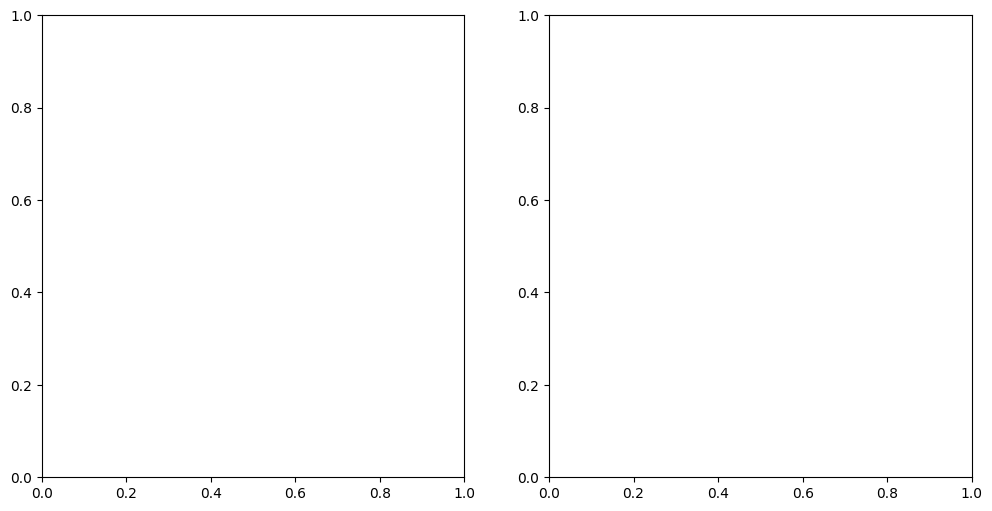

In [ ]:
test_img_path = f"{PATH}/images/28f4a31a-frame_707.jpg"
img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
img_preproccsed, _ = load_and_preprocess_image_and_coords_lines(test_img_path, enhance_lines=True, resize=True)

fig, ax = plt.subplots(1,2, figsize=(12, 6))
if False:

    ax[0].imshow(img)
    ax[0].set_title("Base Image")

    ax[1].imshow(img_preproccsed)
    ax[1].set_title("Preprocessed Image")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


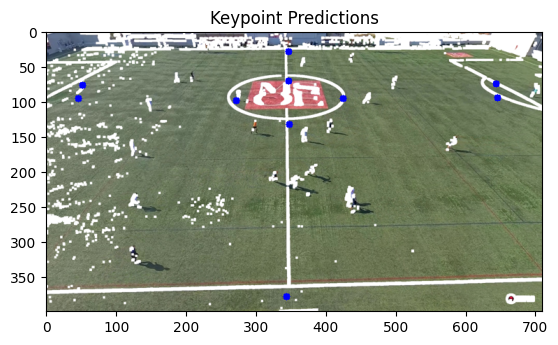

In [ ]:
y_pred_vis, y_pred_xy = model.predict(np.array([img_preproccsed]))
image = visualize_keypoints(image=img_preproccsed, keypoints=y_pred_xy.squeeze()[y_pred_vis.squeeze().round().astype(int) == 1])
plt.imshow(image)
plt.title("Keypoint Predictions")
plt.show()

In [ ]:
# Example dimensions
TARGET_SIZE = (710, 400)  # width, height
X_combined = np.concatenate([np.array(X_train), np.array(X_val)], axis=0)
y_vis_combined = np.concatenate([np.array(y_visibility_train), np.array(y_visibility_val)], axis=0)
y_coords_combined = np.concatenate([np.array(y_coordinates_train), np.array(y_coordinates_val)], axis=0)
mae = compute_homography_mae_over_dataset(
    X=X_combined,
    y_pred_vis=y_vis_combined,
    y_pred_xy=y_coords_combined,
    dest_keypoints=dest_keypoints,
    target_size=TARGET_SIZE,
    affine = False
)

print(mae)


In [ ]:
transformed_pts, H = calculate_H(y_pred_xy.squeeze() , y_pred_vis.squeeze())
plot_in_2D(transformed_pts)

In [ ]:
y_pred_vis, y_pred_xy = model.predict(X_combined)

In [ ]:
mae = compute_homography_mae_over_dataset(
    X=X_combined,
    y_pred_vis=y_pred_vis,
    y_pred_xy=y_pred_xy,
    dest_keypoints=dest_keypoints,
    target_size=TARGET_SIZE,
    affine = False
)
print(mae)


In [ ]:
y_pred_vis, y_pred_xy = model.predict(X_combined)

In [ ]:

projection_error = compute_projection_error_over_dataset(
    X_combined,
    y_pred_vis,
    y_pred_xy,
    y_vis_combined,
    y_coords_combined
)
print(projection_error)


In [ ]:
plt.imshow(visualize_keypoints(
    image=X_val[0],
    keypoints=y_coordinates_val[0],
))

In [ ]:
def get_dataset():
    labels_data = json.load(open(f"{PATH}/{LABELS_JSON}", "r"))

    for sample in labels_data:
        assert len(sample["annotations"]) == 1

    keypoint_labels = []

    for i, sample in enumerate(labels_data):
        keypoint_labels += get_sample_information(sample, i)

    keypoint_labels_df = pd.DataFrame(keypoint_labels)
    transformed_pts, H = calculate_H(y_coordinates_val[3], y_visibility_val[3])

    
    all_labels = keypoint_labels_df.label.value_counts().keys().tolist()

    # Apply function to each frame
    df_filled = keypoint_labels_df.groupby("file", group_keys=False).apply(
        lambda group: fill_missing_labels(group, all_labels)
    )

    # Sort to maintain consistent label order within each frame
    df_filled = df_filled.sort_values(by=["label_frame_index", "label"]).reset_index(
        drop=True
    )

    return df_filled


In [ ]:
Keypoints_in_2D = {
    "Left Bottom Corner": (0, WIDTH_FIELD),
    "Right Bottom Corner": (LENGTH_FIELD, WIDTH_FIELD),
    "Left Top Corner": (0, 0),
    "Right Top Corner": (LENGTH_FIELD, 0),
    "Left Top Box Corner": (LENGTH_BOX, (WIDTH_FIELD / 2)- (WIDTH_BOX/2)),
    "Left Bottom  Box Corner": (LENGTH_BOX, (WIDTH_FIELD / 2)+ (WIDTH_BOX/2)),
    "Box Top Right  Corner": (LENGTH_FIELD - LENGTH_BOX, (WIDTH_FIELD / 2)- (WIDTH_BOX/2)),
    "Box Bottom Right Corner": (LENGTH_FIELD - LENGTH_BOX, (WIDTH_FIELD / 2)+ (WIDTH_BOX/2)),
}

In [ ]:
def scale_keypoints(keypoints):
    """
    Scale the keypoints to the target size.
    """
    scale_x, scale_y = get_scale_factors()
    scaled_keypoints = []
    for keypoint in keypoints:
        x = keypoint[0] * scale_x
        y = keypoint[1] * scale_y
        scaled_keypoints.append((x, y))
    return np.array(scaled_keypoints)

In [ ]:
scaled_keypoints = scale_keypoints(Keypoints_in_2D.values())
scaled_keypoints

In [ ]:
def apply_homography(points_2d, H):
    # Convert to homogeneous coordinates: (N, 2) → (N, 3)
    H_inv = np.linalg.inv(H)

    # Prepare for perspectiveTransform
    points = np.array(points_2d, dtype=np.float32).reshape(-1, 1, 2)

    # Apply inverse homography
    sideview_points = cv2.perspectiveTransform(points, H_inv)
    sideview_points = sideview_points.reshape(-1, 2)
        # Normalize: divide by width and height
    norm_x = sideview_points[:, 0] / TARGET_SIZE[0]
    norm_y = sideview_points[:, 1] / TARGET_SIZE[1]

    normalized = np.stack([norm_x, norm_y], axis=1)
    for index, x, y in enumerate(normalized):
        if x < 0 or x > 1 or y < 0 or y > 1:
            normalized[index][0] = -1
            normalized[index][1] = -1
    return normalized

In [ ]:
apply_homography(scaled_keypoints, H)

In [ ]:
transformed_pts, H = calculate_H(y_coordinates_val[3], y_visibility_val[3])

plt.imshow(visualize_keypoints(
    image=X_val[3],
    keypoints=apply_homography(scaled_keypoints, H),
))

# 6 Player Detection

In [ ]:
import torch

torch.cuda.empty_cache()

In [ ]:
from ultralytics import YOLO

yolo_model = YOLO("yolov8x.pt")

In [ ]:
img = cv2.imread(f"{PATH}/images/f19e8eb9-frame_427.jpg")
img = cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB)

results = yolo_model(img)
annotated_img = results[0].plot()

# Display with matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(annotated_img)
plt.axis("off")
plt.title("YOLOv8 Detection Results")
plt.show()

And then we can also apply homography to these points.

In [ ]:
bottom_points = []

for box in results[0].boxes:
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()  # (x1, y1, x2, y2)

    # normalize by the image being inferenced on
    x1 /= annotated_img.shape[1]
    y1 /= annotated_img.shape[0]
    x2 /= annotated_img.shape[1]
    y2 /= annotated_img.shape[0]
    
    # Bottom-center of bounding box
    bottom_x = (x1 + x2) / 2
    bottom_y = y2
    
    bottom_points.append([bottom_x, bottom_y])
    
bottom_points_np = np.array(bottom_points, dtype=np.float32)
normalized_pts = bottom_points_np.copy()

transformed_bottom_pts = transform_points(normalized_pts, H)
plot_in_2D(transformed_bottom_pts)

In [ ]:
normalized_pts

# 7 Team Recognition

We can use KMeans based on pixel values to help us make predictions of what teams are where on the field.

In [ ]:
box_color_map = []
image_w_boxes= results[0].plot()
for box in results[0].boxes:
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
    
    # Middle pixel
    mid_x = int((x1 + x2) / 2)
    mid_y = int((y1 + y2) / 2)

    # Sample BGR color at middle pixel
    color = results[0].plot()[mid_y, mid_x]  # shape (3,) → [B, G, R]
    box_color_map.append({
        "box": (x1, y1, x2, y2),
        "color": color
    })

In [ ]:
def extract_box_colors(results, img, patch_size=5):
    """Extract average color from the center patch of each detected box."""
    box_infos = []
    colors = []

    for box in results:
        x1, y1, x2, y2 = box

        mid_x = int((x1 + x2) / 2)
        mid_y = int((y1 + y2) / 2)

        half_patch = patch_size // 2
        patch = img[max(0, mid_y - half_patch):mid_y + half_patch + 1,
                    max(0, mid_x - half_patch):mid_x + half_patch + 1]

        avg_color = patch.mean(axis=(0, 1)) if patch.size > 0 else np.array([0, 0, 0])
        box_infos.append(((x1, y1, x2, y2), avg_color))
        colors.append(avg_color)

    return box_infos, np.array(colors)

In [ ]:
def group_boxes_by_color_distance(box_infos, threshold=100):
    """Group boxes manually based on color distance threshold."""
    groups = []

    for box, color in box_infos:
        assigned = False
        for group in groups:
            dist = np.linalg.norm(color - group["color"])
            if dist < threshold:
                group["boxes"].append(box)
                assigned = True
                break
        if not assigned:
            groups.append({
                "color": color,
                "boxes": [box]
            })

    return groups

In [ ]:

colors = np.array([entry["color"] for entry in box_color_map])
kmeans = KMeans(n_clusters=2).fit(colors)

# Add cluster labels
for idx, entry in enumerate(box_color_map):
    entry["cluster"] = int(kmeans.labels_[idx])

In [ ]:
def cluster_boxes_by_kmeans(box_infos, colors, n_clusters=2):
    """Cluster box colors using KMeans."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(colors)
    clustered_boxes = {i: [] for i in range(n_clusters)}

    for i, (box, color) in enumerate(box_infos):
        cluster = kmeans.labels_[i]
        clustered_boxes[cluster].append(box)

    return clustered_boxes, kmeans

In [ ]:
def cluster_boxes_by_kmeans(box_infos, colors, n_clusters=2):
    """Cluster box colors using KMeans and make sure white is always cluster 0."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(colors)

    # Step 1: Get cluster centers and find the one closest to white (255, 255, 255)
    white = np.array([255, 255, 255])
    distances = np.linalg.norm(kmeans.cluster_centers_ - white, axis=1)
    white_cluster_idx = np.argmin(distances)  # Closest to white

    # Step 2: Remap cluster labels so white is always cluster 0
    label_mapping = {white_cluster_idx: 0}
    next_label = 1
    for i in range(n_clusters):
        if i != white_cluster_idx:
            label_mapping[i] = next_label
            next_label += 1

    # Step 3: Apply remapping to boxes
    clustered_boxes = {i: [] for i in range(n_clusters)}
    for i, (box, color) in enumerate(box_infos):
        original_cluster = kmeans.labels_[i]
        mapped_cluster = label_mapping[original_cluster]
        clustered_boxes[mapped_cluster].append(box)

    return clustered_boxes, kmeans


In [ ]:
def calculate_teams(results, img, n_clusters=2, patch_size=3):
    """Full pipeline: extract box colors, cluster using KMeans."""
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    box_infos, colors = extract_box_colors(results, img)
    clustered_boxes, kmeans = cluster_boxes_by_kmeans(box_infos, colors, n_clusters)
    return clustered_boxes, kmeans

In [ ]:
from sklearn.cluster import KMeans

clustered_boxes, kmeans_model = calculate_teams(results, img, n_clusters=3)

In [ ]:
clustered_boxes

In [ ]:
colors_for_clusters = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Add more if needed

for cluster_id, boxes in clustered_boxes.items():
    color = colors_for_clusters[cluster_id % len(colors_for_clusters)]
    for (x1, y1, x2, y2) in boxes:
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
plt.figure(figsize=(12, 8))

plt.imshow(img)

In [ ]:

box_infos = []
colors = []

for box in results[0].boxes:
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

    # Middle of the box
    mid_x = int((x1 + x2) / 2)
    mid_y = int((y1 + y2) / 2)

    # Extract a small patch (5x5) around the center to avoid noise
    patch = img[max(0, mid_y-2):mid_y+3, max(0, mid_x-2):mid_x+3]

    # Compute average color of patch
    avg_color = patch.mean(axis=(0, 1))  # BGR

    box_infos.append(((x1, y1, x2, y2), avg_color))
    colors.append(avg_color)

colors = np.array(colors)

# Run KMeans on the colors
k = 2  # or 3 if you expect 3 groups (e.g., 2 teams + ref)
kmeans = KMeans(n_clusters=k, random_state=0).fit(colors)

# Assign cluster labels
clustered_boxes = {i: [] for i in range(k)}
for i, (box, color) in enumerate(box_infos):
    cluster = kmeans.labels_[i]
    clustered_boxes[cluster].append(box)


In [ ]:
# Copy original image
vis_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Assign random color per cluster
# cluster_colors = [tuple(np.random.randint(0, 255, 3).tolist()) for _ in range(k)]
cluster_colors = [
    (255, 0, 0),
    (0, 0, 255),
]

for cluster_id, boxes in clustered_boxes.items():
    color = cluster_colors[cluster_id]
    for x1, y1, x2, y2 in boxes:
        cv2.rectangle(vis_img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(
            vis_img,
            f"Team {cluster_id+1}",
            (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            color,
            1,
        )

# Convert to RGB for display with matplotlib
vis_img_rgb = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(vis_img_rgb)
plt.axis("off")
plt.title("YOLO Boxes Grouped by Jersey Color")
plt.show()

And we can put this all together using the homography projection!

In [ ]:
import matplotlib.markers as mmarkers

field_img = cv2.imread(viets_field_img)
field_img = cv2.cvtColor(field_img, cv2.COLOR_BGR2RGB)
cluster_labels = kmeans.labels_

# Display the transformed image
plt.figure(figsize=(10, 6))
plt.imshow(field_img)
plt.scatter(
    [int(x) for x, _ in transformed_pts],
    [int(y) for _, y in transformed_pts],
    c="white",
    s=8,
    label="Keypoint",
)

# Team 1
plt.scatter(
    transformed_bottom_pts[cluster_labels == 0, 0],
    transformed_bottom_pts[cluster_labels == 0, 1],
    c="blue",
    s=42,
    label="Opponent",
    marker='x'
)

# Team 2
plt.scatter(
    transformed_bottom_pts[cluster_labels == 1, 0],
    transformed_bottom_pts[cluster_labels == 1, 1],
    c="red",
    s=42,
    label="MSOE",
    marker=mmarkers.MarkerStyle('o', fillstyle='none')
)

plt.axis("off")
plt.title("Soccer Player Homography")
legend = plt.legend(
    bbox_to_anchor=(1.01, 1),
    loc="upper left",
)
frame = legend.get_frame()
frame.set_facecolor("lightgray")
plt.xlim(0, field_img.shape[1])
plt.ylim(field_img.shape[0], 0)
plt.show()

In [ ]:
players_grouped

# 8. Applying all steps into a video

Recognising with yolo

In [ ]:
# video_path = '/data/ai_club/SoccerStats2024/30SecondsAurora.mp4'
# output_path = '/data/ai_club/SoccerStats2024/AuroraVideo2D.mp4'
# cap = cv2.VideoCapture(video_path)

# fps = cap.get(cv2.CAP_PROP_FPS)
# viets_field_img_obj = cv2.imread(viets_field_img)
# viets_field_img_height, viets_field_img_width = viets_field_img_obj.shape[:2]


# field_small_width = 300  # or any size you want
# field_small_height = int(viets_field_img_height * (field_small_width / viets_field_img_width))
# viets_field_small = cv2.resize(viets_field_img_obj, (field_small_width, field_small_height))
# field_alpha = 0.5  # transparency level

# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter(output_path, fourcc, fps, (viets_field_img_width, viets_field_img_height))

# H_smooth = None
# alpha = 0.8  
# last_positions = None

# frame_idx = 0
# while cap.isOpened() and frame_idx <300:
#     new_map = viets_field_img_obj.copy()
#     ret, frame = cap.read()
#     if not ret:
#         print("Brokem")
#         break
        

#     if frame_idx % 3 == 0:
#         # === Your Pipeline ===
#         results_video = yolo_model(frame)[0].boxes.xyxy
#         players_pos = extract_normalized_bottom_centers(results_video, frame.shape[:2])
#         players_grouped, _ = calculate_teams(results, img, n_clusters=2)
#         frame, coord = load_and_preprocess_image_and_coords_lines(frame)
#         frame_input = np.expand_dims(frame, axis=0)  # Add batch dimension

#         y_pred_vis, y_pred_xy = model.predict(frame_input)
#         y_pred_vis = y_pred_vis.squeeze().round().astype(int)



#         if sum(y_pred_vis) >= 4:
#             _, H = calculate_H(y_pred_xy.squeeze(), y_pred_vis.squeeze())
#             H_smooth = alpha * H_smooth + (1 - alpha) * H if H_smooth is not None else H

#             player_2d_positions = transform_points(players_pos, H_smooth)
#             last_positions = player_2d_positions
#             # === Optional: Draw on frame ===
# #             for pt in player_2d_positions:
# #                 x, y = int(pt[0]), int(pt[1] )  # scale if needed
# #                 cv2.circle(new_map, (x, y), 5, (0, 255, 0), -1)
#             for group_id, boxes in players_grouped.items():
#                 color = group_colors.get(group_id, (0, 255, 0))  # Default green if undefined
#                 for box in boxes:
#                     pt = box_to_2d.get(tuple(box))
#                     if pt is not None:
#                         x, y = int(pt[0]), int(pt[1])
#                         cv2.circle(new_map, (x, y), 5, color, -1)
#     elif last_positions is not None:
#         for pt in last_positions:
#             x, y = int(pt[0]), int(pt[1])
#             cv2.circle(new_map, (x, y), 5, (0, 255, 0), -1)
#     cv2.putText(new_map, f"Frame {frame_idx}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
#                 1, (255, 255, 255), 2)
#     out.write(new_map)
#     frame_idx += 1

# cap.release()
# out.release()
# print("Processing complete.")

In [7]:
# Load the video_segments dictionary from the file
with open("/data/ai_club/SoccerStats2024/adrian_video.pkl", 'rb') as f:
    bboxes = pickle.load(f)

In [8]:
with open("/data/ai_club/SoccerStats2024/ball_220frames_filled_smooth.pkl", 'rb') as f:
    ball_positions = pickle.load(f)

In [9]:
from collections import defaultdict


video_path = '/data/ai_club/SoccerStats2024/30SecondsAurora.mp4'
cap = cv2.VideoCapture(video_path)

player_color_sum = defaultdict(lambda: np.zeros(3))
player_color_count = defaultdict(int)

frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame_idx >= len(bboxes):
        
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    player_boxes = bboxes[frame_idx]  # {id: [(x1, y1, x2, y2)]}

    # Build list of just box coords for your function
    flat_boxes = []
    id_lookup = []

    for player_id, boxes in player_boxes.items():
        for box in boxes:
            flat_boxes.append(box)
            id_lookup.append(player_id)

    # Use your function to extract chest-patch colors
    box_infos, _ = extract_box_colors(flat_boxes, frame)

    for i, (box, avg_color) in enumerate(box_infos):
        player_id = id_lookup[i]
        player_color_sum[player_id] += avg_color
        player_color_count[player_id] += 1

    frame_idx += 1

cap.release()


In [10]:
player_avg_color = {}

for player_id in player_color_sum:
    player_avg_color[player_id] = (
        player_color_sum[player_id] / player_color_count[player_id]
    )

In [11]:
player_ids = list(player_avg_color.keys())
color_values = np.array([player_avg_color[pid] for pid in player_ids])  # shape: (N, 3)

# Run KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(color_values)
labels = kmeans.labels_  # labels[i] corresponds to player_ids[i]

# Map player_id → cluster (0 or 1)
player_id_to_group = {
    player_ids[i]: int(labels[i])
    for i in range(len(player_ids))
}

In [9]:
player_avg_color

{1: array([     111.75,       122.7,      134.03]),
 2: array([     145.89,      139.07,       151.5]),
 3: array([     89.952,      98.911,      127.06]),
 4: array([     144.55,      155.41,      84.804]),
 5: array([     140.71,      140.64,      151.19]),
 6: array([     80.755,      97.685,      120.12]),
 7: array([     75.949,      98.442,      115.96]),
 8: array([     137.77,       143.9,       158.8]),
 9: array([     78.699,      97.415,      108.17]),
 10: array([     79.461,      99.964,      122.29]),
 11: array([     145.79,      144.32,      157.96]),
 12: array([     135.27,      139.26,      149.74]),
 13: array([     144.77,      142.98,      155.35]),
 14: array([     86.071,      106.21,      120.28]),
 15: array([      89.06,       97.31,      118.52]),
 16: array([     79.676,      99.056,      110.99]),
 17: array([     136.14,       142.3,      147.07]),
 18: array([     109.15,      125.12,      123.84]),
 19: array([     131.97,      143.51,      145.16]),
 2

In [10]:
player_id_to_group

{1: 1,
 2: 0,
 3: 1,
 4: 2,
 5: 0,
 6: 1,
 7: 1,
 8: 0,
 9: 1,
 10: 1,
 11: 0,
 12: 0,
 13: 0,
 14: 1,
 15: 1,
 16: 1,
 17: 0,
 18: 1,
 19: 0,
 20: 1,
 21: 0,
 22: 0,
 23: 1}

Creating map from video

In [ ]:
# # Define paths for input video and output video
# video_path = '/data/ai_club/SoccerStats2024/30SecondsAurora.mp4'
# output_path = '/data/ai_club/SoccerStats2024/AuroraVideo2D.mp4'

# # Open the video file
# cap = cv2.VideoCapture(video_path)

# # Get the frames per second (fps) of the video
# fps = cap.get(cv2.CAP_PROP_FPS)
# print(fps)

# # Load the field image and get its dimensions
# viets_field_img_obj = cv2.imread(viets_field_img)
# viets_field_img_height, viets_field_img_width = viets_field_img_obj.shape[:2]

# # Resize the field image for overlay purposes
# field_small_width = 300  # Desired width for the resized field image
# field_small_height = int(viets_field_img_height * (field_small_width / viets_field_img_width))
# viets_field_small = cv2.resize(viets_field_img_obj, (field_small_width, field_small_height))
# field_alpha = 0.5  # Transparency level for overlay

# # Initialize the video writer for the output video
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter(output_path, fourcc, fps, (viets_field_img_width, viets_field_img_height))

# # Initialize variables for smoothing and tracking
# H_smooth = None
# alpha = 0.8  # Smoothing factor for homography matrix
# frame_idx = 0
# last_group_positions = {}  # Dictionary to store last known positions of players

# # Process each frame of the video
# while cap.isOpened():
#     # Create a copy of the field image for drawing
#     new_map = viets_field_img_obj.copy()
    
#     # Read the next frame from the video
#     ret, frame = cap.read()
#     if not ret:
#         print("Brokem")  # Break the loop if no frame is read
#         break
    
#     # Convert the frame to RGB format
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
#     # Process every second frame
#     if frame_idx % 2 == 0:
#         # Get bounding boxes for players in the current frame
#         player_boxes_frame = bboxes[frame_idx]  # {player_id: [(x1, y1, x2, y2)]}

#         # Flatten bounding boxes and track player IDs
#         flat_boxes = []
#         player_id_list = []
#         for player_id, boxes in player_boxes_frame.items():
#             for box in boxes:
#                 flat_boxes.append(box)
#                 player_id_list.append(player_id)

#         # Extract bottom-center points of bounding boxes
#         player_positions = extract_normalized_bottom_centers(flat_boxes, frame.shape[:2])

#         # Preprocess the frame for keypoint detection
#         frame_preprocessed, coord = load_and_preprocess_image_and_coords_lines(frame)
#         frame_input = np.expand_dims(frame_preprocessed, axis=0)

#         # Predict visibility and keypoints using the model
#         y_pred_vis, y_pred_xy = model.predict(frame_input)
#         y_pred_vis = y_pred_vis.squeeze().round().astype(int)

#         # If sufficient keypoints are visible, calculate homography
#         if sum(y_pred_vis) >= 4:
#             _, H = calculate_H(y_pred_xy.squeeze(), y_pred_vis.squeeze())
#             H_smooth = alpha * H_smooth + (1 - alpha) * H if H_smooth is not None else H

#             # Transform player positions to 2D field coordinates
#             player_2d_positions = transform_points(player_positions, H_smooth)

#             # Update last known positions of players
#             last_group_positions = {}
#             for idx, player_id in enumerate(player_id_list):
#                 pt = player_2d_positions[idx]
#                 if player_id not in last_group_positions:
#                     last_group_positions[player_id] = []
#                 last_group_positions[player_id].append(pt)

#             # Draw players on the field using their group colors
#             for player_id, points in last_group_positions.items():
#                 group = player_id_to_group.get(player_id)  # Get group ID for the player
#                 color = group_colors.get(group)  # Get color for the group
#                 for pt in points:
#                     x, y = int(pt[0]), int(pt[1])
#                     cv2.circle(new_map, (x, y), 14, color, -1)

#     # If not processing the current frame, use the last known positions
#     elif last_group_positions:
#         for player_id, points in last_group_positions.items():
#             group = player_id_to_group.get(player_id)
#             color = group_colors.get(group)
#             for pt in points:
#                 x, y = int(pt[0]), int(pt[1])
#                 cv2.circle(new_map, (x, y), 14, color, -1)

#     # Write the processed frame to the output video
#     out.write(new_map)
#     frame_idx += 1

# # Release resources
# cap.release()
# out.release()
# print("Processing complete.")

In [14]:
import importlib
import heatmap

In [42]:
import distance_speed_stimator
importlib.reload(distance_speed_stimator)

from distance_speed_stimator import *
importlib.reload(heatmap)
import stimating_team_position
importlib.reload(stimating_team_position)
from stimating_team_position import update_zone_tracking
import possesion_tracker
importlib.reload(possesion_tracker)
from possesion_tracker import *


In [ ]:
# Define paths for input video and output video
video_path = '/data/ai_club/SoccerStats2024/30SecondsAurora.mp4'
output_path_3D = '/data/ai_club/SoccerStats2024/AuroraVideo3D.mp4'
tracker = PossessionTracker(3, 3)

# Open the video file
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"FPS: {fps}, Resolution: {frame_width}x{frame_height}")

# Load the field image and get its dimensions
viets_field_img_obj = cv2.imread(viets_field_img)
viets_field_img_height, viets_field_img_width = viets_field_img_obj.shape[:2]

# 3D VideoWriter (draw speed directly on video frame)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out3D = cv2.VideoWriter(output_path_3D, fourcc, fps, (frame_width, frame_height))

# Tracking variables
H_smooth = None
alpha = 0.8
frame_idx = 0
last_group_positions = {}  # player_id -> (pt_2d, frame_pt, group, color, speed)
reset_player_history()
# Process frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Video read error or finished.")
        break
    frame_orig = frame.copy()
    # frame_orig = cv2.resize(frame_orig, (TARGET_SIZE[0], TARGET_SIZE[1]))
    frame_orig = cv2.cvtColor(frame_orig, cv2.COLOR_RGB2BGR)

    if frame_idx % 5 == 0:
        frame_preprocessed, coord = load_and_preprocess_image_and_coords_lines(frame_orig)
        frame_input = np.expand_dims(frame_preprocessed, axis=0)
        y_pred_vis, y_pred_xy = model.predict(frame_input)
        y_pred_vis = y_pred_vis.squeeze().round().astype(int)

        if sum(y_pred_vis) >= 4:
            _, H = calculate_H(y_pred_xy.squeeze(), y_pred_vis.squeeze())
            H_smooth = alpha * H_smooth + (1 - alpha) * H if H_smooth is not None else H
    if frame_idx % 2 == 0 and H_smooth is not None:
        player_boxes_frame = bboxes.get(frame_idx, {})  # {player_id: [(x1, y1, x2, y2)]}
        
        flat_boxes = []
        player_id_list = []
        for player_id, boxes in player_boxes_frame.items():
            for box in boxes:
                flat_boxes.append(box)
                player_id_list.append(player_id)
        # Extract bottom-center positions of players
        player_positions = extract_normalized_bottom_centers(flat_boxes, frame_orig.shape[:2])  # image-space points


        if sum(y_pred_vis) >= 4:
            
            player_2d_positions = transform_points(player_positions, H_smooth)
            draw_data = []
            for idx, player_id in enumerate(player_id_list):
                pt_2d = player_2d_positions[idx]
                frame_pt = player_positions[idx]  # original frame position
                group = player_id_to_group.get(player_id)

                update_player_history(player_id, pt_2d, frame_idx, group)
                speed, last_distance = calculate_speed_distance_mps(player_id, fps)
                total_distance = update_player_stats(player_id, speed, last_distance)

                color = group_colors.get(group)
                draw_data.append((player_id, pt_2d, frame_pt, group, color, speed, total_distance))
            detect_off_ball_run(10, 0, fps)

            # Store data for next frame
            last_group_positions = {
                player_id: (pt_2d, frame_pt, group, color, speed, total_distance)
                for player_id, pt_2d, frame_pt, group, color, speed, total_distance in draw_data
            }
            # update_zone_tracking(last_group_positions)
            player_positions = {
                player_id: pt_2d
                for player_id, pt_2d, _, _, _, _, _ in draw_data
            }
            # 
            ## LOGIC FOR BALL
            ball_box = ball_positions[frame_idx]
            if len(ball_box) == 4:
                ball_position_normalized = extract_normalized_bottom_centers([ball_box], frame_orig.shape[:2])
                ball_2d_position = transform_points(ball_position_normalized, H_smooth)
                last_ball_position = ball_2d_position[0]
            
            tracker.update_possession(last_ball_position, player_positions,  player_id_to_group)

    # Draw current or previous positions with speed on 3D frame
    for player_id, (pt_2d, frame_pt, group, color, speed, total_distance) in last_group_positions.items():
        frame_x, frame_y = int(frame_pt[0] * frame_width), int(frame_pt[1] * frame_height)
        speed_text = f"{speed:.1f} m/s"
        total_distance_text = f"Dist: {total_distance:.1f} m"
        cv2.circle(frame_orig, (frame_x, frame_y), 8, color, -1)
        cv2.putText(frame_orig, speed_text, (frame_x + 10, frame_y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(frame_orig, total_distance_text, (frame_x + 10, frame_y + 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    ## Draw ball position
    ball_x, ball_y = int(ball_box[0] * frame_width), int(ball_box[1] * frame_height)
    cv2.circle(frame_orig, (ball_x, ball_y), 8, (0, 255, 0), -1)
    cv2.putText(frame_orig, "Ball", (ball_x + 10, ball_y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    # Draw total possession of ball
    total_possession = tracker.get_total_possession()
    team_0_possession = total_possession.get(0, 0)
    team_1_possession = total_possession.get(1, 0)

    # Format possession text
    possession_text_0 = f"Team 0: {team_0_possession:.1f}%"
    possession_text_1 = f"Team 1: {team_1_possession:.1f}%"

    # Define the box dimensions for the top-right corner
    box_width, box_height = 600, 70
    box_x, box_y = frame_width - box_width - 20, 20  # 20px margin from the top-right corner

    # Draw the box for Team 0
    cv2.rectangle(frame_orig, (box_x, box_y), (box_x + box_width, box_y + box_height), (0, 0, 0), -1)
    cv2.putText(frame_orig, possession_text_0, (box_x + 10, box_y + 45),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)

    # Draw the box for Team 1 below Team 0
    box_y_below = box_y + box_height + 10  # Add 10px margin between boxes
    cv2.rectangle(frame_orig, (box_x, box_y_below), (box_x + box_width, box_y_below + box_height), (0, 0, 0), -1)
    cv2.putText(frame_orig, possession_text_1, (box_x + 10, box_y_below + 45),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)

    # Save frame
    out3D.write(cv2.cvtColor(frame_orig, cv2.COLOR_RGB2BGR))
    frame_idx += 1
# heatmap = create_player_heatmap(player_id= 10)
# Cleanup
cap.release()
out3D.release()
print("Processing complete.")

FPS: 30.0, Resolution: 3840x2160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Zone (2, 2): Team 1 possession count: 1
Zone (2, 2): Team 1 possession count: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Zone (2, 2): Team 1 possession count: 3
Zone (2, 2): Team 1 possession count: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Zone (2, 2): Team 1 possession count: 5
Zone (2, 2): Team 1 possession count: 6
Zone (2, 2): Team 1 possession count: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Zone (2, 2): Team 1 possession count: 8
Zone (2, 2): Team 1 possession count: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Zone (2, 2): Team 1 possession count: 10
Zone (2, 2): Team 1 possession count: 11
Zone (2, 2): Team 1 possession count: 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Zone (2, 2): Team 1 possession count: 13
Zone (2, 2): Team 1 possession count: 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Zone (2, 2): Team 1 possession count: 15
Zone (2, 2): Team 1 possession count: 16
Zone (2, 2): Team 1 possession count: 17
1/1 ━━━━━━━━━

In [45]:
print_off_ball_runs(10)

In [27]:
def draw_team_possession_heatmap(self, team_id, output_path="team_possession_heatmap.jpg", alpha=0.6):
    """
    Draws a heatmap of possession percentages for a given team using different tones of white with transparency.
    """
    # Load the field image
    field_image = cv2.imread(viets_field_img)
    field_image = cv2.cvtColor(field_image, cv2.COLOR_BGR2RGB)

    # Create a blank heatmap with the same dimensions as the field image
    heatmap = np.zeros_like(field_image, dtype=np.uint8)

    # Draw vertical and horizontal lines to separate zones
    for col in range(1, self.vertical_zones):
        x = col * self.zone_width
        cv2.line(heatmap, (x, 0), (x, self.field_height), (255, 0, 0), 3)  # Blue lines
    for row in range(1, self.horizontal_zones):
        y = row * self.zone_height
        cv2.line(heatmap, (0, y), (self.field_width, y), (255, 0, 0), 3)  # Blue lines

    # Overlay possession percentages for the given team
    possession_percentages = self.get_possession_percentages()
    for row in range(self.horizontal_zones):
        for col in range(self.vertical_zones):
            percentages = possession_percentages.get((row, col), {})
            team_percent = percentages.get(team_id, 0)

            # Calculate the intensity of white based on possession percentage
            intensity = int(255 * (team_percent / 100))
            color = (intensity, intensity, intensity)  # Shades of white

            # Fill the zone with the calculated color
            top_left = (col * self.zone_width, row * self.zone_height)
            bottom_right = ((col + 1) * self.zone_width, (row + 1) * self.zone_height)
            cv2.rectangle(heatmap, top_left, bottom_right, color, -1)

            # Add possession percentage text
            x = int((col + 0.5) * self.zone_width)
            y = int((row + 0.5) * self.zone_height)
            cv2.putText(
                heatmap,
                f"{team_percent:.1f}%",
                (x - 30, y),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (0, 0, 0),  # Black text for contrast
                2,
                cv2.LINE_AA,
            )

    # Blend the heatmap with the field image
    blended_image = cv2.addWeighted(heatmap, alpha, field_image, 1 - alpha, 0)

    # Save the heatmap image
    cv2.imwrite(output_path, cv2.cvtColor(blended_image, cv2.COLOR_RGB2BGR))
    print(f"Team possession heatmap saved to {output_path}")

In [28]:
draw_team_possession_heatmap(tracker, team_id=0, output_path="team_0_possession_heatmap.jpg")

Team possession heatmap saved to team_0_possession_heatmap.jpg


In [81]:
def get_top_distance_players(top_n=5):
    """Return the top N players with the highest distance covered."""
    player_stats = get_player_stats()
    sorted_players = sorted(player_stats.items(), key=lambda item: item[1][1], reverse=True)
    return sorted_players[:top_n]

In [88]:
def display_top_distance_players(top_n=5):
    """Display a horizontal bar chart of the top N players with the highest distance covered."""
    top_players = get_top_distance_players(top_n)
    player_ids = [str(player_id) for player_id, _ in top_players]  # Convert IDs to strings
    distances = [distance for _, (_, distance) in top_players]

    plt.figure(figsize=(10, 6))
    plt.barh(player_ids, distances, color='skyblue')
    plt.ylabel('Player ID')
    plt.xlabel('Distance Covered (m)')
    plt.title(f'Top {top_n} Players by Distance Covered')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest distance at the top
    plt.tight_layout()
    plt.show()

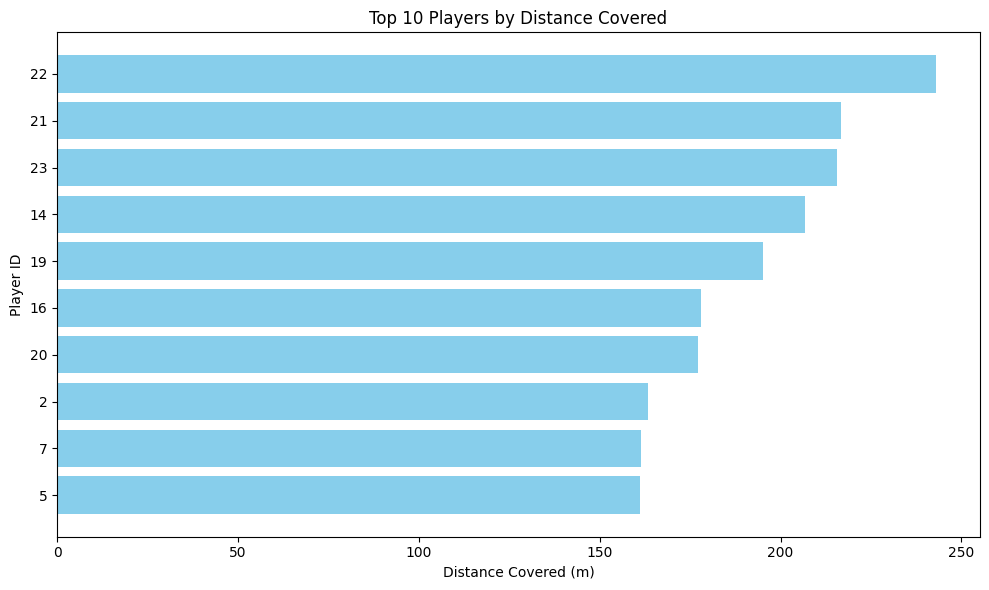

In [89]:
display_top_distance_players(10)

In [82]:
get_top_distance_players(5)

[(22, (92.65888152073205, 242.97247946718124)),
 (21, (50.665920286395604, 216.59692262980784)),
 (23, (42.21824118660019, 215.7106686158677)),
 (14, (68.28877592743902, 206.70128308356203)),
 (19, (35.886458382188394, 195.00519716207188))]

In [ ]:
heatmap  = create_player_heatmap(player_id= 10)     
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)     
cv2.imwrite("test_heatmap.png", heatmap)

In [8]:
video_path = '/data/ai_club/SoccerStats2024/30SecondsAurora.mp4'
frames = []
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

cap.release()
frames = np.array(frames)
image = frames[88]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


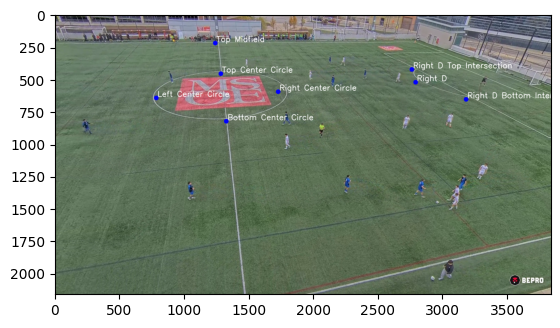

In [ ]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
frame_preprocessed, coord = load_and_preprocess_image_and_coords_lines(image)
frame_input = np.expand_dims(frame_preprocessed, axis=0)
y_pred_vis, y_pred_xy = model.predict(frame_input)
vis_mask = y_pred_vis.round().astype(int).flatten() == 1

y_pred_xy = y_pred_xy[0][vis_mask]
visible_labels = np.array(list(dest_keypoints.keys()))[vis_mask]

image_after = visualize_keypoints(image=image, keypoints=y_pred_xy.squeeze(), labels =visible_labels, radius =18, font_scale=2, font_thickness=3)
cv2.imwrite('/data/ai_club/SoccerStats2024/ImagesSlides/keypoints.jpg', cv2.cvtColor(image_after, cv2.COLOR_RGB2BGR))

plt.imshow(image_after)

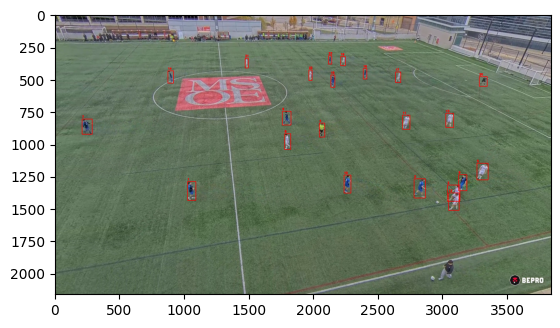

In [ ]:
image_with_boxes = image.copy()

for player_id, boxes in bboxes[88].items():
    for box in boxes:
        if len(box) == 4:
            x1, y1, x2, y2 = box
            cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=4)
            cv2.putText(image_with_boxes, str(player_id), (x1, y1 - 10),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=(0, 0, 255), thickness=4)
cv2.imwrite('/data/ai_club/SoccerStats2024/ImagesSlides/image_boxes.jpg', image_with_boxes)
image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_RGB2BGR)

plt.imshow(image_with_boxes)

In [11]:
cluster_colors = [
    (255, 255, 255),  # Cluster 0 → white ✅
    (255, 0, 0),      # Cluster 1 → dark blue (BGR) ✅
    (0, 255, 255),    # Cluster 2 → bright yellow (BGR) ✅
]


In [27]:
image_with_cluster_boxes = frames[310].copy()


for player_id, box_list in bboxes[310].items():
    cluster_id = player_id_to_group.get(player_id, 0)
    color = cluster_colors[cluster_id]

    for box in box_list:
        if len(box) != 4:
            continue  # skip invalid boxes

        x1, y1, x2, y2 = box

        # cv2.rectangle(image_with_cluster_boxes, (x1, y1), (x2, y2), color=color, thickness=4)
        # cv2.putText(image_with_cluster_boxes, str(player_id), (x1, y1 - 10),
        #             fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=color, thickness=4)
        
cv2.imwrite('/data/ai_club/SoccerStats2024/ImagesSlides/image_boxes_clusters_after.jpg',image_with_cluster_boxes)



True

In [ ]:
##how to reload python file
import importlib
import video_creator
importlib.reload(video_creator)
from video_creator import *


In [ ]:
plot_video_3D(frames, bboxes, player_id_to_group, ball_positions, output_path="/data/ai_club/SoccerStats2024/ImagesSlides/players_and_ball_video.mp4", fps=30)

Video saved to /data/ai_club/SoccerStats2024/ImagesSlides/players_and_ball_video.mp4


In [ ]:
ima = cv2.imread(viets_field_img)
print(ima.shape)

(897, 1507, 3)


In [ ]:
plot_2D_map(frames, bboxes, player_id_to_group, ball_positions, output_path="/data/ai_club/SoccerStats2024/ImagesSlides/2d_map.mp4",
                              fps=30, model =model)

NameError: name 'plot_2D_map' is not defined

In [44]:
import importlib
import possesion_tracker
importlib.reload(possesion_tracker)
from possesion_tracker import *


In [ ]:
# Initialize the possession tracker before the loop
tracker = PossessionTracker(zone_count=3)
H_smooth = None
alpha = 0.8
last_group_positions = {}  # player_id -> (pt_2d, frame_pt, group, color, speed, total_distance)

# Start looping through frames
for frame_idx, frame in enumerate(frames):
    frame_orig = frame.copy()
    frame_orig = cv2.cvtColor(frame_orig, cv2.COLOR_RGB2BGR)
    if frame_idx % 5 == 0:
        frame_preprocessed, coord = load_and_preprocess_image_and_coords_lines(frame_orig)
        frame_input = np.expand_dims(frame_preprocessed, axis=0)
        y_pred_vis, y_pred_xy = model.predict(frame_input)
        y_pred_vis = y_pred_vis.squeeze().round().astype(int)

        if sum(y_pred_vis) >= 4:
            _, H = calculate_H(y_pred_xy.squeeze(), y_pred_vis.squeeze())
            H_smooth = alpha * H_smooth + (1 - alpha) * H if H_smooth is not None else H

    if frame_idx % 2 == 0 and H_smooth is not None:
        player_boxes_frame = bboxes.get(frame_idx, {})  # {player_id: [(x1, y1, x2, y2)]}
        
        flat_boxes = []
        player_id_list = []
        for player_id, boxes in player_boxes_frame.items():
            for box in boxes:
                flat_boxes.append(box)
                player_id_list.append(player_id)
        # Extract bottom-center positions of players
        player_positions = extract_normalized_bottom_centers(flat_boxes, frame_orig.shape[:2])  # image-space points


        if sum(y_pred_vis) >= 4:
            player_2d_positions = transform_points(player_positions, H_smooth)
            draw_data = []
            for idx, player_id in enumerate(player_id_list):
                pt_2d = player_2d_positions[idx]
                frame_pt = player_positions[idx]  # original frame position
                group = player_id_to_group.get(player_id)

                update_player_history(player_id, pt_2d, frame_idx, group)
                # speed, last_distance = calculate_speed_distance_mps(player_id, fps)
                # total_distance = update_player_stats(player_id, speed, last_distance)
                # color = group_colors.get(group)
                # draw_data.append((player_id, pt_2d, frame_pt, group, color, speed, total_distance))
                last_group_positions[player_id] = tuple(pt_2d)

            # update_zone_tracking(last_group_positions)

                # ---- BALL POSITION TRACKING ----
            last_ball_position = None  # Reset each frame

            if frame_idx < len(ball_positions) and H_smooth is not None:
                ball_box = ball_positions[frame_idx]
                if len(ball_box) == 4:
                    ball_position_normalized = extract_normalized_bottom_centers([ball_box], frame_orig.shape[:2])
                    ball_2d_position = transform_points(ball_position_normalized, H_smooth)
                    last_ball_position = ball_2d_position[0]


    print("Frame Index:", frame_idx)
    # ---- POSSESSION UPDATE ----
    tracker.update_possession(
        ball_position=last_ball_position,
        player_positions=last_group_positions,
        player_id_to_group=player_id_to_group
    )


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Frame Index: 0
Frame Index: 1
Frame Index: 2
Zone 3: Team 1 possession count: 1
Frame Index: 3
Zone 3: Team 1 possession count: 2
Frame Index: 4
Zone 3: Team 1 possession count: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Frame Index: 5
Zone 3: Team 1 possession count: 4
Frame Index: 6
Frame Index: 7
Frame Index: 8
Frame Index: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Frame Index: 10
Frame Index: 11
Frame Index: 12
Zone 3: Team 1 possession count: 5
Frame Index: 13
Zone 3: Team 1 possession count: 6
Frame Index: 14
Zone 3: Team 1 possession count: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Frame Index: 15
Zone 3: Team 1 possession count: 8
Frame Index: 16
Frame Index: 17
Frame Index: 18
Frame Index: 19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Frame Index: 20
Frame Index: 21
Frame Index: 22
Frame Index: 23
Frame Index: 24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Frame Index: 25
Frame Index: 26
Frame Index: 27
Frame Index: 28
Frame Index: 29
1/1 ━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
plt.imshow(frames[486])

In [37]:
tracker.get_possession_percentages()
tracker.print_summary()
tracker.draw_zones_with_possession()


Possession by Zone:
Zone 1:
  Team 1: 100.0%
Zone 2:
  Team 0: 96.0%
  Team 1: 4.0%
Zone 3:
  Team 1: 78.6%
  Team 0: 21.4%
Zones map with possession saved to zones_with_possession_map.jpg


In [ ]:
percentages = get_zone_occupancy_percentages()
percentages

{0: {'defensive_third': 0.0,
  'middle_third': 27.27272727272727,
  'attacking_third': 72.72727272727273},
 1: {'defensive_third': 0.0,
  'middle_third': 41.66666666666667,
  'attacking_third': 50.0}}

In [ ]:
import importlib
import stimating_team_position
importlib.reload(stimating_team_position)
from stimating_team_position import draw_zone_occupancy_overlay


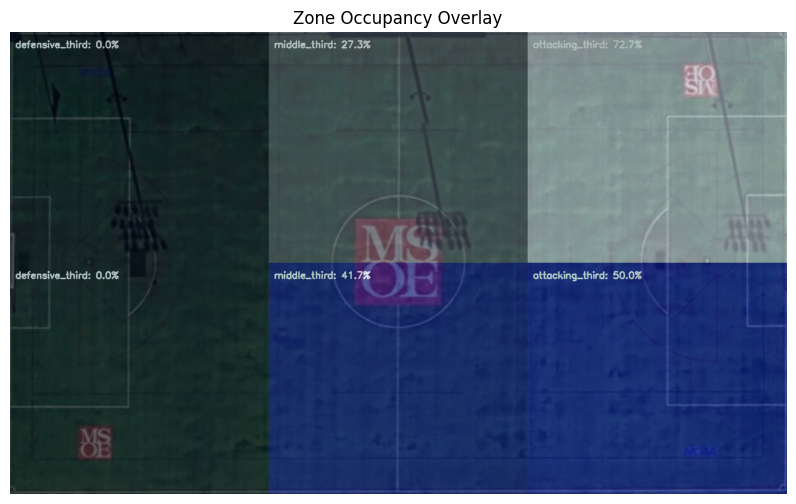

In [ ]:
image_percentages = draw_zone_occupancy_overlay(percentages)
img_rgb = cv2.cvtColor(image_percentages, cv2.COLOR_BGR2RGB)

# Display it
plt.figure(figsize=(12, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Zone Occupancy Overlay")
plt.show()